In [1]:
import cv2
import numpy as np
import operator
import warnings
import sys
from matplotlib import pyplot as plt

from utils import *
from fatching_copy import *
from values import *
from minutiae import *
from roc import *
from collections import defaultdict

from sklearn.metrics import accuracy_score, precision_score, f1_score
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

In [2]:
def get_roc_curve(frr, far):
    plt.title('ROC curve')
    x_axis = np.array(far) # False Positive (Accept / Match) Rate
    y_axis = np.array(frr) # False Reject Rate = 1 - TPR
    plt.plot(x_axis, y_axis) # x, y
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('False Reject Rate (FRR)')
    plt.xlabel('False Accept Rate (FAR)')
    plt.grid(True)
    plt.show()

In [3]:
# Returns feature descripors for all images from the dataset
def get_feature_descriptors(dataset ):
    feature_descriptors = {}
    for image_id, image in dataset.items():
        kp, des = orb.detectAndCompute(image, None)
        feature_descriptors[image_id] = des
    return feature_descriptors


# Returns best_matches between training features descriptors and query image
def get_best_matches(query_image, trained_features, distance_threshold): 
    best_matches_dict = {}
    kp1, query_des = orb.detectAndCompute(query_image, None) # features of the query image
    for train_image_id, trained_feature_des in trained_features.items():
        if query_des is not None and trained_feature_des is not None:
            matches = bf.match(query_des, trained_feature_des)
            matches = list(matches)
            matches.sort(key=lambda x: x.distance, reverse=False) # sort matches based on feature distance
            
            best_matches = [m.distance for m in matches if m.distance < distance_threshold]
            best_matches_dict[train_image_id] = len(best_matches) # matching function = length of best matches to given threshold
    
    best_matches_dict = sorted(best_matches_dict.items(), key = operator.itemgetter(1), reverse=True) # sort by value - feature distance
    return best_matches_dict

In [4]:
# Apply homography to test and train image
# Homography or image alignment: to perfectly line up the features in two images
def apply_homography(query_image, closest_image):
    kp1, des1 = orb.detectAndCompute(query_image, None)
    kp2, des2 = orb.detectAndCompute(closest_image, None)
    matches = bf.match(des1, des2)

    # Apply homography
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # M matrix that represents the homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use homography
    height, width = query_image.shape[:2]
    # The function warpPerspective transforms the source image using the specified matrix
    im1Reg = cv2.warpPerspective(closest_image, M, (width, height))

    # Plot aligned query and train image
    plt.subplot(1, 2, 1)
    plt.imshow(im1Reg, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(query_image, cmap='gray')
    plt.show()

In [5]:
def classify_fpr(best_matches_dict, rank):
    '''
    Counts how many fprs from the same class are there in the first ranked 
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param rank: To take the first ranked closest features
    :return first_rank_sorted: dictionary, where key denotes the fpr class and 
            the value is how many times it appears in the first ranked fprs
    '''
    first_rank_fprs = defaultdict(int)
    for fpr_name, distance in best_matches_dict[0:rank]:
        fpr_class = get_image_class(fpr_name)
        first_rank_fprs[fpr_class] += 1
            
    first_rank_sorted = sorted(first_rank_fprs.items(), key = operator.itemgetter(1), reverse=True) 
    return first_rank_sorted

In [6]:
def draw_keypoints_matches(fpr1, fpr2):
    kp1, des1 = orb.detectAndCompute(fpr1, None) 
    kp2, des2 = orb.detectAndCompute(fpr2, None)

    matches = bf.match(des1, des2)
    matches = list(matches)
    matches.sort(key=lambda x: x.distance, reverse=False)
    imMatches = cv2.drawMatches(fpr1, kp1, fpr2, kp2,matches[:10], None)

    plt.imshow(imMatches)
    plt.show()


# Definition of identification scenario
def perform_identification_scenario(dist_threshold, rank, should_draw):
    true_y = []
    pred_y = []
    total_prob = 0
    print("----- START, threshold = {}, rank = {} -----".format(dist_threshold, rank))
    for test_image_id, test_image in test_set.items():
        # Get the distances between the query image and all other training images
        best_matches_dict = get_best_matches(test_image, train_feature_descriptors, dist_threshold)
        # print("Test image: {}, best matches: {}".format(test_image_id, best_matches_dict[0:rank]))
        true_class = get_image_class(test_image_id)
                
        # Classify the first closest features according to the given rank
        first_rank_fprs = classify_fpr(best_matches_dict, rank)
        predicted_class = first_rank_fprs[0][0]
        prob = first_rank_fprs[0][1] / TRAIN_PER_CLASS 
        total_prob += prob
        true_y.append(true_class) # true_class
        pred_y.append(predicted_class)
            
        if should_draw:  # Check whether to draw the homography and the matching keypoints
            closest_img_id = best_matches_dict[0][0]
            closest_img = train_set.get(closest_img_id)
            apply_homography(test_image, closest_img)  # image alignment
            draw_keypoints_matches(test_image, closest_img)
            print('Query fingerprint ID: ' + test_image_id)
            print('Best matching fingerprint ID: ' + closest_img_id)

    avg_probability = total_prob/len(test_set)
    print("Averaged probability for rank %d and threshold %d is %f "%(rank, dist_threshold, avg_probability))
    print("Accuracy for rank %d and threshold %d is %f "%(rank, dist_threshold, accuracy_score(true_y, pred_y)))
    return avg_probability

In [7]:
def count_same_fprs(feature_distances, len_best_matches):
    '''
    Counts how many fprs are close to the query fpr
    :param feature_distances: Feature distaces from given query fpr to all training fprs
    :param len_best_matches: Predefined value for the length of best features
    :return count_same: number of same fprs paris within the given len_best_matches
    '''
    count_same = 0
    for features in feature_distances:
        if int(features[1]) > len_best_matches: # Compare the len of best features for the given feature with the predefined len
            count_same += 1
            
    return count_same


def perform_authentication_scenario(dist_threshold, len_best_matches):
    true_y = []
    pred_y = []
    total_distances = []
    print("----- START, Threshold = {} -----".format(dist_threshold))
    for authentication_db_key in authentication_databases.keys():
        authentication_db = authentication_databases[authentication_db_key]
        for test_image_id, test_image in test_set.items():    
            best_matches_dict = get_best_matches(test_image, authentication_db, dist_threshold)
            # print("Test image: {}, best matches: {}".format(test_image_id, best_matches_dict[0:len_best_matches]))
            total_distances.append(best_matches_dict[0])
            
            count_same = count_same_fprs(best_matches_dict, len_best_matches)
            ratio = count_same/len(authentication_db.keys())
            test_image_class = get_image_class(test_image_id)
            true_class = 1 if test_image_class == authentication_db_key else 0
            true_y.append(true_class)
            
            if ratio >= 0.5: 
                pred_y.append(1)
            else:
                pred_y.append(0) 
    
    identical = true_y
    print("Accuracy is %f "%(round(accuracy_score(true_y, pred_y),4)))
    print('The precision score is {}'.format(precision_score(true_y, pred_y)))
    print('F1 score is {}'.format(round(f1_score(true_y, pred_y), 4)))

    return total_distances, identical

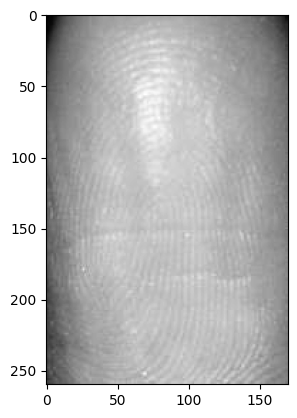

In [8]:
img = sys.argv[1]
img1 = cv2.imread("dbc/c1_1.bmp" , cv2.IMREAD_GRAYSCALE)
sc1 = cv2.imread("Database/Final_BMP/Scanner/s1_1.bmp" , cv2.IMREAD_GRAYSCALE)
plt.imshow(img1,cmap = 'gray')

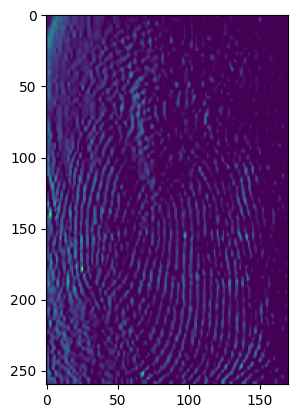

In [9]:
def edgedet(img):
    k= np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    convolve = cv2.filter2D(gray, -1, k)
    return convolve


img11 = cv2.imread("dbc/c1_1.bmp")
sc11 = cv2.imread("Database/Final_BMP/Scanner/s1_1.bmp")
res2 = edgedet(img11)
scres2 = edgedet(sc11)
plt.imshow(res2)

# CLAHE ALGORITHM

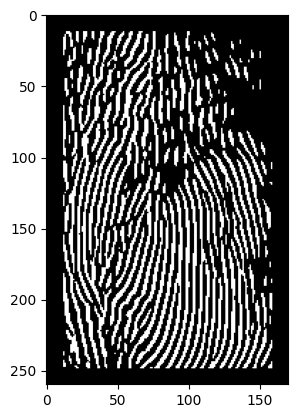

In [10]:
import fingerprint_enhancer	
gray_img = grayscale_image(res2)
img2 = fingerprint_enhancer.enhance_Fingerprint(gray_img)
plt.imshow(img2,cmap = 'gray')
# plt.savefig('processed.png')

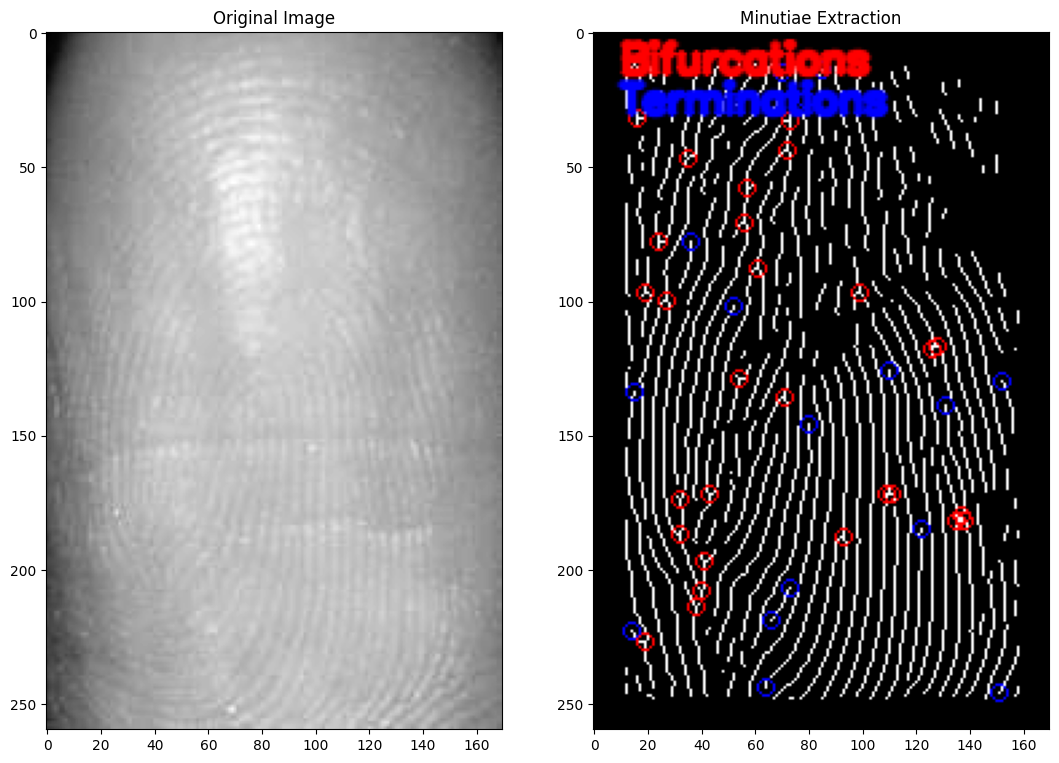

In [11]:
#-----------------------calling minutiae and display result-----------------------------------------
FeaturesTerminations, FeaturesBifurcations,DispImg = extract_minutiae_features(img2, showResult=True)
font = cv2.FONT_HERSHEY_SIMPLEX

color = (255, 0, 0)
org = (10, 15)
DispImg = cv2.putText(DispImg, 'Bifurcations', org, font,0.5, color,2, cv2.LINE_AA)
color1 = (0, 0, 255)
org1 = (10, 30)
DispImg = cv2.putText(DispImg, 'Terminations', org1, font,0.5, color1,2, cv2.LINE_AA)
plt.figure(figsize = (20,20))
plt.subplot(1,3,1), plt.imshow(img1,cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,3,2), plt.imshow(DispImg,cmap = 'gray')
plt.title('Minutiae Extraction')
plt.show()

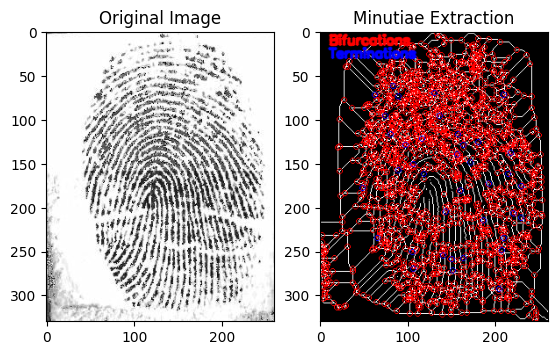

In [12]:
#-----------------------calling minutiae and display result-----------------------------------------
FeaturesTerminations, FeaturesBifurcations,DispImg = extract_minutiae_features(sc1, showResult=True)
font = cv2.FONT_HERSHEY_SIMPLEX
color = (255, 0, 0)
org = (10, 15)
DispImg = cv2.putText(DispImg, 'Bifurcations', org, font,0.5, color,2, cv2.LINE_AA)
color1 = (0, 0, 255)
org1 = (10, 30)
DispImg = cv2.putText(DispImg, 'Terminations', org1, font,0.5, color1,2, cv2.LINE_AA)
plt.figure(figsize = (10,10))
plt.subplot(1,3,1), plt.imshow(sc1,cmap = 'gray')
plt.title('Original Image')
plt.subplot(1,3,2), plt.imshow(DispImg,cmap = 'gray')
plt.title('Minutiae Extraction')
plt.show()

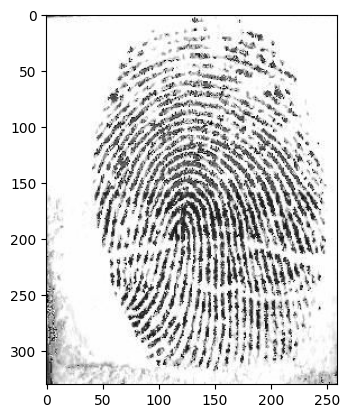

In [13]:
img = cv2.imread('/Users/bhavi/Desktop/preprop/Database/Final_JPEG/Scanner/s1_1.jpg')
plt.imshow(img)


In [14]:
#-----------------------------read database----------------------------------
file_names = read_images()
# print(file_names.__len__())
train_set, test_set = prepare_dataset(file_names)

print('Size of the training set:', len(train_set))
print('Size of the test set:', len(test_set))

--------
Processing image c100_1.jpg ...  
--------
Processing image c100_2.jpg ...  
--------
Processing image c100_3.jpg ...  
--------
Processing image c100_4.jpg ...  
--------
Processing image c101_1.jpg ...  
--------
Processing image c101_2.jpg ...  
--------
Processing image c101_3.jpg ...  
--------
Processing image c101_4.jpg ...  
--------
Processing image c102_1.jpg ...  
--------
Processing image c102_2.jpg ...  
--------
Processing image c102_3.jpg ...  
--------
Processing image c102_4.jpg ...  
--------
Processing image c103_1.jpg ...  
--------
Processing image c103_2.jpg ...  
--------
Processing image c103_3.jpg ...  
--------
Processing image c103_4.jpg ...  
--------
Processing image c104_1.jpg ...  
--------
Processing image c104_2.jpg ...  
--------
Processing image c104_3.jpg ...  
--------
Processing image c104_4.jpg ...  
--------
Processing image c105_1.jpg ...  
--------
Processing image c105_2.jpg ...  
--------
Processing image c105_3.jpg ...  
--------
Pr

In [18]:
# Initiate ORB detector for matching keypoints
orb = cv2.ORB_create(MAX_FEATURES)
# get type of orb
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


train_feature_descriptors = get_feature_descriptors(train_set)

print()
print("---------------------With Fix rank and variable thresold-----------------------------")
print()

rank = 3
for dist_threshold in range(20, 70, 10): 
    perform_identification_scenario(dist_threshold, rank, False)


print()
print("----------------------With Fix thresold and variable rank----------------------------")
print()
dist_threshold = 50
avg_probabilities = []
rank_range = range(1, 10, 1) 
for rank in rank_range:
    avg_probabilities.append(perform_identification_scenario(dist_threshold, rank, False))


print()
print("--------------------------------------------------")
print()

authentication_databases = prepare_dataset_authentication(train_feature_descriptors)
print('Classes in the training set = {}'.format(authentication_databases.keys()))


# Example 
# --- For query image: 101_2.tif ---
# Probability of correct fpr for class 101 = 0.8333
# We can notice that there are ~ 83% chances that the person will be correctly authenticated.

# test_image_id = list(test_set)[0]

<class 'cv2.ORB'>

---------------------With Fix rank and variable thresold-----------------------------

----- START, threshold = 20, rank = 3 -----
Averaged probability for rank 3 and threshold 20 is 0.500000 
Accuracy for rank 3 and threshold 20 is 0.111111 
----- START, threshold = 30, rank = 3 -----
Averaged probability for rank 3 and threshold 30 is 0.500000 
Accuracy for rank 3 and threshold 30 is 0.111111 
----- START, threshold = 40, rank = 3 -----
Averaged probability for rank 3 and threshold 40 is 0.500000 
Accuracy for rank 3 and threshold 40 is 0.111111 
----- START, threshold = 50, rank = 3 -----
Averaged probability for rank 3 and threshold 50 is 0.462963 
Accuracy for rank 3 and threshold 50 is 0.111111 
----- START, threshold = 60, rank = 3 -----
Averaged probability for rank 3 and threshold 60 is 0.314815 
Accuracy for rank 3 and threshold 60 is 0.333333 

----------------------With Fix thresold and variable rank----------------------------

----- START, threshold = 5

--- For query image: c102_2.jpg ---
Probability of correct fpr for class c108 = 0.0


[ WARN:0@31.615] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('c102_2.jpg'): can't open/read file: check file path/integrity


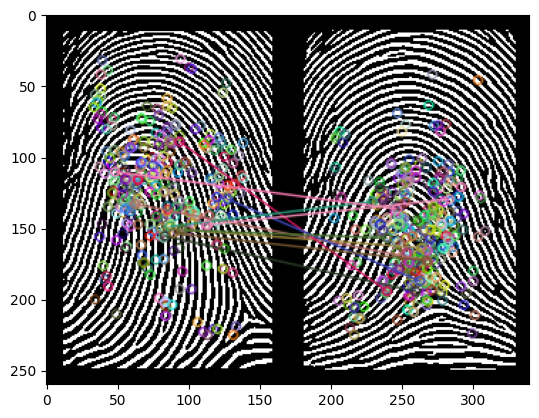


------------------------A--------------------------

----- START, Threshold = 30 -----
Accuracy is 0.888900 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 40 -----


/Users/bhavi/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.888900 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 50 -----


/Users/bhavi/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.888900 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 60 -----


/Users/bhavi/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.888900 
The precision score is 0.0
F1 score is 0.0
----- START, Threshold = 50 -----


/Users/bhavi/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is 0.888900 
The precision score is 0.0
F1 score is 0.0

---------------------------EER , FAR and FRR-----------------------

Equal Error Rate is: 0.4514
Generating ROC curve: False accept rates vs. false reject rates


/Users/bhavi/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


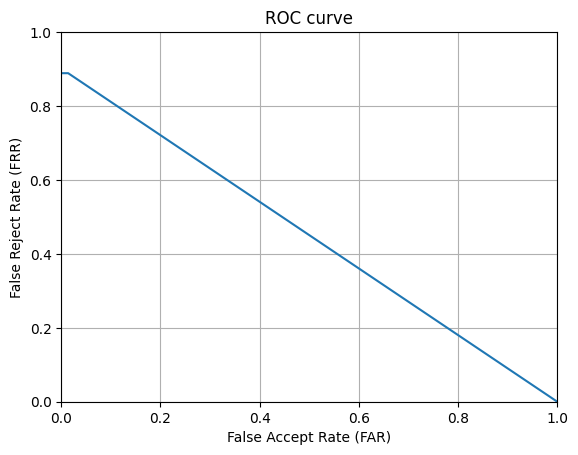

In [16]:
# test_image_id="105_2.tif"
# image_name = sys.argv[1]
# test_image_id=image_name

# take any image from test set
test_image_id = list(test_set)[2]
test_image = cv2.imread(test_image_id, cv2.IMREAD_GRAYSCALE)
# take any image from train set
train_image_id = list(train_set)[1]

id=''
final_ratio=0
for p_id, p_info in authentication_databases.items():
    authentication_db = authentication_databases[p_id]
    best_matches_dict = get_best_matches(test_set[test_image_id], authentication_db , 50) 
    count_same = count_same_fprs(best_matches_dict, 10)
    ratio = count_same/len(authentication_db.keys())
    if(ratio >= final_ratio):
        final_ratio=ratio
        id=p_id

print('--- For query image: {} ---'.format(test_image_id))
print('Probability of correct fpr for class {} = {}'.format(id,round(ratio,4)))
draw_keypoints_matches(test_set[test_image_id], train_set[train_image_id])

print()
print("------------------------A--------------------------")
print()

len_best_matches = 15
for dist_threshold in range(30, 70, 10): 
    perform_authentication_scenario(dist_threshold, len_best_matches)


distances, identical = perform_authentication_scenario(50, len_best_matches)
genuine_scores, impostor_scores = get_genuine_impostor_scores(distances, identical)
# print(distances)
# print(identical)
print()
print("---------------------------EER , FAR and FRR-----------------------")
print()

stats = get_eer_stats(genuine_scores, impostor_scores)
generate_eer_report([stats], ['A'], 'pyeer_report.csv')

# PyEER is a Python package intended for biometric systems performance evaluation. 
# This package is used for computing the EER, as well as the FAR and FRR later.
# EER represents a point where both FAR and FRR are equal.
eer = round(stats.eer, 4)
print('Equal Error Rate is: {}'.format(eer))

print('Generating ROC curve: False accept rates vs. false reject rates')
get_roc_curve(stats.fnmr, stats.fmr)

In [17]:
print("Test image: {}, best matches: {}".format(test_image_id, best_matches_dict[0:rank]))


Test image: c102_2.jpg, best matches: [('c108_4.jpg', 0), ('c108_1.jpg', 0), ('c108_3.jpg', 0)]
